In [1]:
#%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from traffic.core import Traffic
from traffic.drawing import countries, rivers
from traffic.data import nm_airspaces
from itertools import islice, cycle
import numpy as np
import pandas as pd
from traffic.core.projection import Lambert93


def plot(tc, cluster_id="cluster"):
    if cluster_id == "cluster":
        n_clusters_ = int(1 + tc.data.cluster.max())
    else:
        n_clusters_ = int(1 + tc.data.cluster_id.max())
    #  -- dealing with colours --

    color_cycle = cycle(
        ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf"]
        + ["#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]
    )

    colors = list(islice(color_cycle, n_clusters_))
    colors.append("#aaaaaa")  # color for outliers, if any

    # -- dealing with the grid --

    nb_cols = 3
    nb_lines = (1 + n_clusters_) // nb_cols + (((1 + n_clusters_) % nb_cols) > 0)

    def ax_iter(axes):
        if len(axes.shape) == 1:
            yield from axes
        if len(axes.shape) == 2:
            for ax_ in axes:
                yield from ax_

    with plt.style.context("traffic"):
        fig, ax = plt.subplots(
            nb_lines, nb_cols, subplot_kw=dict(projection=Lambert93())
        )

        for cluster, ax_ in zip(range(-1, n_clusters_), ax_iter(ax)):
            ax_.add_feature(countries())
            ax_.add_feature(rivers())

            tc.query(f"{cluster_id} == {cluster}").plot(ax_, color=colors[cluster])

            ax_.set_extent(nm_airspaces["LFBBBDX"])

In [2]:
def good_flight(flight):
    return flight.duration > pd.Timedelta("5 minutes")


t = Traffic.from_file("~/traffic/traffic/data/sample_opensky.pkl")
t_filtered = (
    t.clean_invalid()
    .assign_id()
    .filter_if(good_flight)
    .filter()
    .filter(altitude=53)
    .resample("5s")
    .resample(50)
    .eval(desc="preprocessing", max_workers=12)
)

t_filtered.data["log_altitude"] = t_filtered.data.altitude.apply(
    lambda x: np.log10(x) if x > 0 else x
)
# t_filtered.data[t_filtered.data.isna().sum(axis=1) > 0]

In [3]:
for flight in t_filtered:
    if sum(flight.data.duplicated(["flight_id", "timestamp"])) > 0:
        print(flight.flight_id, flight.duration)

In [3]:
import logging

logFormatter = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(format=logFormatter, level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from sectflow.clustering import TrajClust

features = ["x", "y", "altitude"]  # , "latitude", "longitude", "altitude"]

tc = t_filtered.clustering(
    nb_samples=2,
    features=features,
    projection=Lambert93(),
    clustering=TrajClust(features, eps=0.6, min_cluster_size_ratio=0.01),
).fit_predict()

INFO:root:Clustering...
INFO:root:Cluster 0: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 1: 4 trajectories = 1.5% of the traffic
INFO:root:Cluster 2: 13 trajectories = 4.8% of the traffic
INFO:root:Cluster 3: 6 trajectories = 2.2% of the traffic
INFO:root:Cluster 4: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 5: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 6: 4 trajectories = 1.5% of the traffic
INFO:root:Cluster 7: 6 trajectories = 2.2% of the traffic
INFO:root:Cluster 8: 19 trajectories = 7.0% of the traffic
INFO:root:Cluster 9: 9 trajectories = 3.3% of the traffic
INFO:root:Cluster 10: 18 trajectories = 6.7% of the traffic
INFO:root:Cluster 11: 16 trajectories = 5.9% of the traffic
INFO:root:Cluster 12: 11 trajectories = 4.1% of the traffic
INFO:root:Cluster 13: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 14: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 15: 6 trajectories = 2.2% of the traffic
INFO:root:Cluster 16: 3 trajectories 

INFO:root:Reading ARE file /home/luis/traffic/data/are/AIRAC_1901/Sectors_1901_Sectors.are
INFO:root:Reading SLS file /home/luis/traffic/data/are/AIRAC_1901/Sectors_1901_Sectors.sls
INFO:root:Reading SPC file /home/luis/traffic/data/are/AIRAC_1901/Sectors_1901_Collapse.spc
/home/luis/.conda/envs/test/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/luis/.conda/envs/test/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


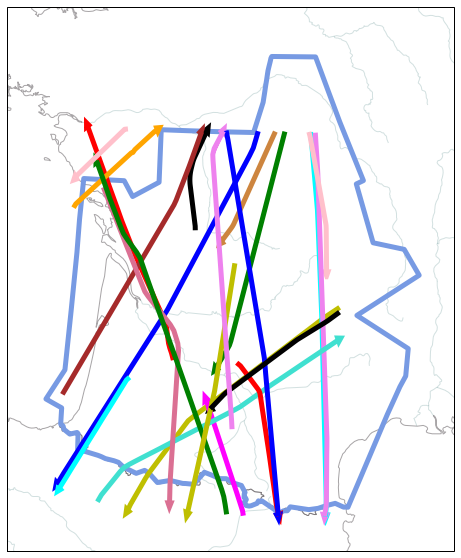

In [4]:
from sectflow.plot import clusters_plot2d

clusters_plot2d(
    nm_airspaces["LFBBBDX"], tc, 50, Lambert93()
)  # , scaler=StandardScaler())

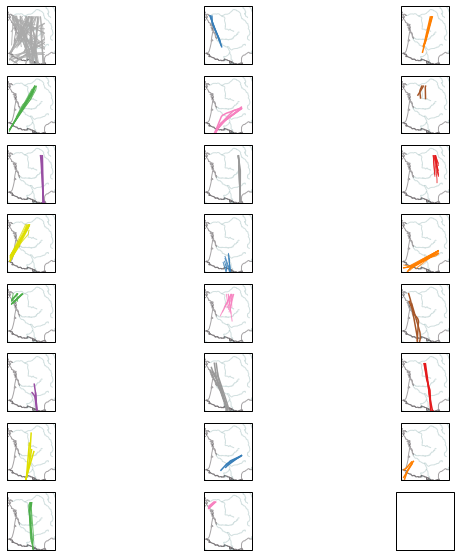

In [5]:
plot(tc)

INFO:root:Clustering...
INFO:root:Cluster 0: 69 trajectories = 5.5% of the traffic
INFO:root:Cluster 1: 53 trajectories = 4.3% of the traffic
INFO:root:Cluster 2: 39 trajectories = 3.1% of the traffic
INFO:root:Cluster 3: 27 trajectories = 2.2% of the traffic
INFO:root:Cluster 4: 28 trajectories = 2.3% of the traffic
INFO:root:Cluster 5: 43 trajectories = 3.5% of the traffic
INFO:root:Cluster 6: 44 trajectories = 3.5% of the traffic
INFO:root:Cluster 7: 60 trajectories = 4.8% of the traffic
INFO:root:Cluster 8: 38 trajectories = 3.1% of the traffic
INFO:root:Cluster 9: 77 trajectories = 6.2% of the traffic
INFO:root:Cluster 10: 46 trajectories = 3.7% of the traffic
INFO:root:Cluster 11: 53 trajectories = 4.3% of the traffic
INFO:root:Cluster 12: 41 trajectories = 3.3% of the traffic
INFO:root:Cluster 13: 39 trajectories = 3.1% of the traffic
INFO:root:Cluster 14: 48 trajectories = 3.9% of the traffic
INFO:root:Cluster 15: 29 trajectories = 2.3% of the traffic
INFO:root:Cluster 16: 29 t

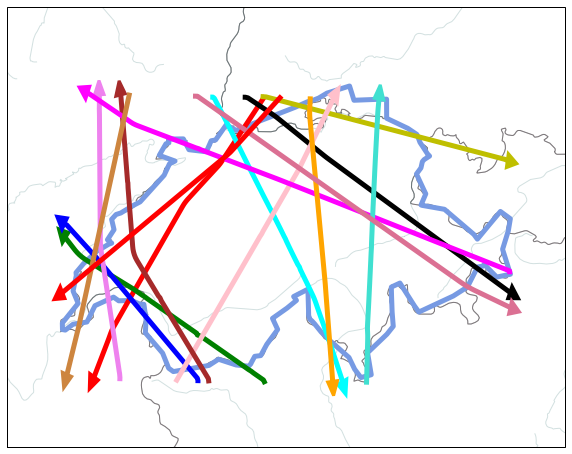

In [7]:
from traffic.data.samples import get_flight
from pathlib import Path

switzerland = get_flight(
    "switzerland", Path("~/traffic/traffic/traffic/data/samples/atm/")
)
import numpy as np

sw = (
    switzerland.assign(
        log_altitude=lambda df: df.altitude.apply(lambda x: np.log10(x) if x > 0 else x)
    )
    .assign_id()
    .eval()
)

from sectflow.clustering import TrajClust
from traffic.core.projection import CH1903

features = ["x", "y", "latitude", "longitude", "altitude", "log_altitude"]

tc = sw.clustering(
    nb_samples=2,
    features=features,
    projection=CH1903(),
    clustering=TrajClust(
        features,
        min_cluster_size_ratio=0.0115,
        # sub_min_cluster_size_ratio=0.01,
        eps=0.5,
        sub_eps=0.5,
    ),
).fit_predict()

from sectflow.plot import clusters_plot2d
from traffic.core.projection import EuroPP

clusters_plot2d(nm_airspaces["LS"], tc, 50, EuroPP(), plot_trajs=False)

In [12]:
from traffic.core.projection import Lambert93

from sklearn.cluster import DBSCAN  # , OPTICS, Birch
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

t_dbscan = t_filtered.clustering(
    nb_samples=15,
    projection=Lambert93(),
    clustering=DBSCAN(eps=1.5, min_samples=10),
    transform=StandardScaler(),
)
t_dbscan.groupby(["cluster"]).agg({"flight_id": "nunique"})

,flight_id
cluster,
-1,157
0,29
1,13
2,24
3,24
4,20
5,15
6,10
7,10


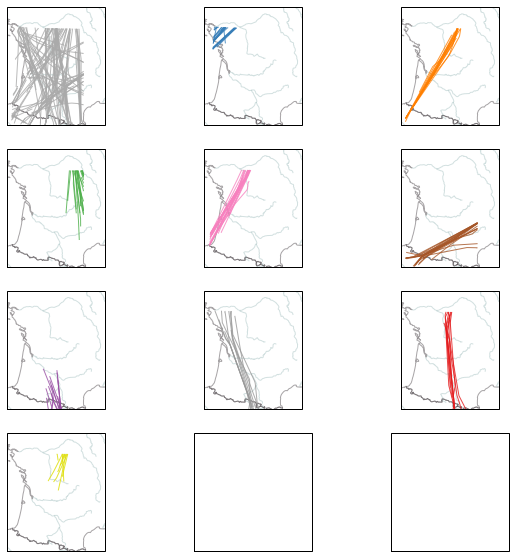

In [13]:
plot(t_dbscan)

In [8]:
t_gmm = t_filtered.clustering(
    nb_samples=15,
    projection=Lambert93(),
    clustering=GaussianMixture(n_components=8),
    transform=StandardScaler(),
)

In [9]:
t_gmm.groupby(["cluster"]).agg({"flight_id": "nunique"})

,flight_id
cluster,
0,31
1,24
2,65
3,58
4,35
5,45
6,31
7,23


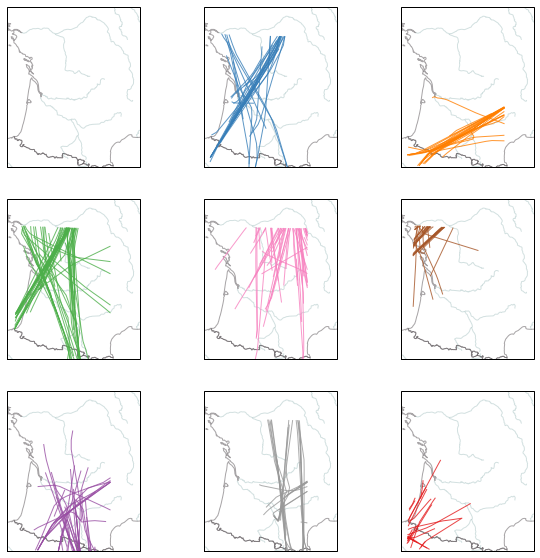

In [10]:
plot(t_gmm)